1. Importa los datos al ambiente de trabajo y revisamos que no haya huecos. Calculamos la
diferencia de promedios entre las clases 2 y 4 para todos los genes, e imprimos los 10
genes con la mayor diferencia de medias. 

In [32]:
# 1. Importación y Análisis Inicial (Versión Mejorada)
import pandas as pd
import numpy as np
import os

# 1.1 Importar los datos (con manejo de errores)
try:
    # Intentar con diferentes nombres comunes del archivo
    try:
        data = pd.read_csv('A3.1_Khan.csv')
    except FileNotFoundError:
        data = pd.read_csv('A3.1 Khan.csv')  # Versión sin guión bajo
    
    print("Datos cargados correctamente")
    
    # 1.2 Verificación de estructura
    print("\nPrimeras filas del DataFrame:")
    print(data.head())
    
    print("\nNombres de columnas disponibles:")
    print(data.columns.tolist())
    
    # 1.3 Búsqueda automática de la columna clase
    possible_class_cols = [col for col in data.columns 
                         if data[col].nunique() <= 4 and data[col].nunique() > 1]
    
    if not possible_class_cols:
        raise ValueError("Error: No se encontró una columna con 2-4 valores únicos que pueda ser la variable clase")
    
    class_col = possible_class_cols[0]
    print(f"\nVariable clase identificada: '{class_col}' con valores {sorted(data[class_col].unique())}")
    
    # 1.4 Separación de características y variable objetivo
    X = data.drop(class_col, axis=1)
    y = data[class_col]
    
    # 1.5 Verificación de valores faltantes
    print("\nValores faltantes totales:", X.isnull().sum().sum())
    
    # 1.6 Cálculo de diferencias de medias (clases 2 vs 4)
    if {2, 4}.issubset(y.unique()):
        class_2 = X[y == 2]
        class_4 = X[y == 4]
        mean_diff = class_2.mean() - class_4.mean()
        top_10_genes = mean_diff.abs().sort_values(ascending=False).head(10)
        
        print("\nTop 10 genes con mayor diferencia absoluta de medias (clase 2 vs 4):")
        print(top_10_genes)
    else:
        print("\nAdvertencia: Las clases 2 y/o 4 no existen en los datos")

except Exception as e:
    print(f"\nError durante la carga/validación: {str(e)}")
    print("Verifica:")
    print("1. Que el archivo existe y tiene el nombre correcto")
    print("2. Que contiene una columna con los valores de clase (1-4)")
    print("3. Que los datos tienen la estructura esperada (genes en columnas)")

Datos cargados correctamente

Primeras filas del DataFrame:
         X1        X2        X3        X4        X5        X6        X7  \
0  0.773344 -2.438405 -0.482562 -2.721135 -1.217058  0.827809  1.342604   
1 -0.078178 -2.415754  0.412772 -2.825146 -0.626236  0.054488  1.429498   
2 -0.084469 -1.649739 -0.241308 -2.875286 -0.889405 -0.027474  1.159300   
3  0.965614 -2.380547  0.625297 -1.741256 -0.845366  0.949687  1.093801   
4  0.075664 -1.728785  0.852626  0.272695 -1.841370  0.327936  1.251219   

         X8        X9       X10  ...     X2300     X2301     X2302     X2303  \
0  0.057042  0.133569  0.565427  ... -0.027474 -1.660205  0.588231 -0.463624   
1 -0.120249  0.456792  0.159053  ... -0.246284 -0.836325 -0.571284  0.034788   
2  0.015676  0.191942  0.496585  ...  0.024985 -1.059872 -0.403767 -0.678653   
3  0.819736 -0.284620  0.994732  ...  0.357115 -1.893128  0.255107  0.163309   
4  0.771450  0.030917  0.278313  ...  0.061753 -2.273998 -0.039365  0.368801   

      X2

# Análisis:
Las diferencias en la expresión de genes como X187 y X509 entre los tipos de cáncer 2 y 4 sugieren que podrían ser clave para distinguir ambos tumores, ya sea por medio de diagnósticos o por medio de estudios. En este estudio de inferencia, encotrar esto nos da pistas valiosas sobre las diferencias biológicas entre estos cánceres, pero es importante confirmarlos con análisis estadísticos más sobustos como con pruebas de significancia o validación cruzada, ya que por ahora solo sabemos que indican una asociación interesante que requiere más investigación para establecer su verdadero significado clínico y biológico.

2. Calcularemos el estadístico t y el p-value para comparar las medias de todos los genes entre la
clase 2 y la clase 4 de la base de datos. Usaremos la metodología de Bonferroni, de Holm, y de
Benjamini-Hochberg para corregir por múltiples pruebas.

Se indicará para cada una qué genes tienen una expresión significativamente distinta entre las clases manejando un control de 0.05.


In [34]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Filtrar datos para clases 2 y 4
class_2 = X[y == 2]
class_4 = X[y == 4]

# Calcular estadístico t y p-values para cada gen
t_stats, p_values = stats.ttest_ind(class_2, class_4, axis=0, equal_var=False)

# Correcciones para múltiples pruebas
methods = ['bonferroni', 'holm', 'fdr_bh']  # Benjamini-Hochberg es 'fdr_bh'
significant_genes = {}

for method in methods:
    # Aplicar corrección
    rejected, corrected_p, _, _ = multipletests(p_values, alpha=0.05, method=method)
    
    # Guardar resultados
    significant_genes[method] = {
        'total_significant': sum(rejected),
        'genes': X.columns[rejected],
        'p_values': corrected_p[rejected]
    }
    
    # Imprimir resumen
    print(f"\nMétodo {method.upper()}:")
    print(f"Genes significativos: {significant_genes[method]['total_significant']}")
    print("Top 10 genes más significativos:")
    top_10_idx = np.argsort(significant_genes[method]['p_values'])[:10]
    for idx in top_10_idx:
        gene = significant_genes[method]['genes'][idx]
        p_val = significant_genes[method]['p_values'][idx]
        print(f"{gene}: p = {p_val:.5f}")


Método BONFERRONI:
Genes significativos: 72
Top 10 genes más significativos:
X1003: p = 0.00000
X187: p = 0.00000
X2050: p = 0.00000
X1955: p = 0.00000
X1645: p = 0.00000
X246: p = 0.00000
X2046: p = 0.00000
X509: p = 0.00000
X1954: p = 0.00000
X1389: p = 0.00000

Método HOLM:
Genes significativos: 72
Top 10 genes más significativos:
X1003: p = 0.00000
X187: p = 0.00000
X2050: p = 0.00000
X1955: p = 0.00000
X1645: p = 0.00000
X246: p = 0.00000
X2046: p = 0.00000
X509: p = 0.00000
X1954: p = 0.00000
X1389: p = 0.00000

Método FDR_BH:
Genes significativos: 296
Top 10 genes más significativos:
X1003: p = 0.00000
X187: p = 0.00000
X2050: p = 0.00000
X1955: p = 0.00000
X1645: p = 0.00000
X246: p = 0.00000
X2046: p = 0.00000
X509: p = 0.00000
X1954: p = 0.00000
X1389: p = 0.00000


# Análisis:
Bonferroni con un criterio más conservador identificó 72 genes con diferencias significativas (p<0.05), incluyendo X1003, X187 y X2050 como los más relevantes p=0. Holm parecido a Bonferroni pero ligeramente menos estricto, también detectó 72 genes significativos, coincidiendo en los primeros 10 genes con Bonferroni. FDR_BH más felxible encontró 296 genes diferenciales, manteniendo los mismos 10 genes top con p=0, pero incluyendo muchos más candidatos posibles. Todos los métodos encuentran que X1003, X187 y X2050 son los genes con diferencias más extremas entre clases.

3. Realizaremos un experimento parecido al anterior, pero ahora comparando las medias de las 4 clases de la
base de datos. Para lograrlo, en vez de trabajar con el estadístico t, probaremos el análisis de varianza ANOVA. Dicha prueba la realizaremos con la funciónf_oneway de scipy.stats, pero para usar la función, necesitaremos primero estratificarlos por clase.

In [36]:
from scipy.stats import f_oneway

# Preparar datos para ANOVA
anova_results = []
for gene in X.columns:
    # Separar datos por clase
    groups = [X[y == cls][gene] for cls in sorted(y.unique())]
    
    # Calcular ANOVA
    f_stat, p_val = f_oneway(*groups)
    anova_results.append({'gene': gene, 'F': f_stat, 'p': p_val})

# Convertir a DataFrame y ordenar
anova_df = pd.DataFrame(anova_results).sort_values('p')

# Corrección Benjamini-Hochberg
rejected, corrected_p, _, _ = multipletests(anova_df['p'], alpha=0.05, method='fdr_bh')
anova_df['significant'] = rejected
anova_df['corrected_p'] = corrected_p

# Resultados
print(f"\nANOVA - Genes significativos: {sum(rejected)}")
print("\nTop 10 genes más significativos:")
print(anova_df[['gene', 'F', 'corrected_p']].head(10))


ANOVA - Genes significativos: 1162

Top 10 genes más significativos:
       gene          F   corrected_p
1954  X1955  84.364086  2.045755e-21
1388  X1389  83.817537  2.045755e-21
1002  X1003  77.795622  1.245542e-20
2049  X2050  69.230799  2.731346e-19
245    X246  68.414042  3.062126e-19
741    X742  65.572797  8.445542e-19
0        X1  59.118264  1.265852e-17
2161  X2162  56.987623  2.986387e-17
1953  X1954  55.419914  5.597246e-17
1644  X1645  54.768403  6.751740e-17


# Análisis:
Ahora, mientras los métodos de comparación directa entre las clases 2 y 4 (Bonferroni, Holm y FDR_BH) identificaron entre 72 y 296 genes significativos, ANOVA que compara simultáneamente detectó un conjunto mucho más amplio, alrededor de 1,162 genes, indicando genes como X1955 (p=2.04e-21) y X1389 como los más significativos. 

Aunque se mantiene cierta coincidencia en genes top como X1955, X1003, X2050, X1645 que aparecían en ambos análisis, el ANOVA revela genes adicionales relevantes, como X742 y X1, que las comparaciones por pares no capturaron, sugiriendo que estos podrían estar expresados diferente en otros contrastes entre clases o mostrar patrones complejos que solo se podrían ver al considerar todas las clases simultáneamente.

4. Separaremos los datos en entrenamiento y prueba, construiremos y entrenaremos un modelo de SVM con
un kernel lineal, con un kernel polinomial de orden 3, y con un kernel radial. Para evitar
que el tiempo de procesamiento sea exagerado, seleccionaremos solamente algunas
variables, partiendo de los resultados que obtuvimos en los puntos anteriores. Pero lo
ideal sería que la selección de características se basara solamente en experimentos
realizados con los datos de entrenamiento. Pero, en este caso, obviaremos este detalle.


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Seleccionar los 50 genes más significativos del ANOVA
selected_genes = anova_df.head(50)['gene'].values
X_selected = X[selected_genes]

# Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Dividir datos (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelos SVM
models = {
    'Lineal': SVC(kernel='linear', C=1, random_state=42),
    'Polinomial (grado 3)': SVC(kernel='poly', degree=3, C=1, random_state=42),
    'RBF': SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
}

# Entrenamiento
for name, model in models.items():
    print(f"\nEntrenando modelo {name}...")
    model.fit(X_train, y_train)


Entrenando modelo Lineal...

Entrenando modelo Polinomial (grado 3)...

Entrenando modelo RBF...


5. Calcularemos, para los 3 modelos, métricas importantes como exactitud (accuracy), precisión, recall (sensibilidad), F1-score y matriz de confusión para comparar los desempeños. analizaremos los resultados, especificando si uno de los kernels es mejor para esta tarea específica, considerando tanto el rendimiento como la complejidad computacional.


=== Evaluación modelo Lineal ===
Exactitud: 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         8

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



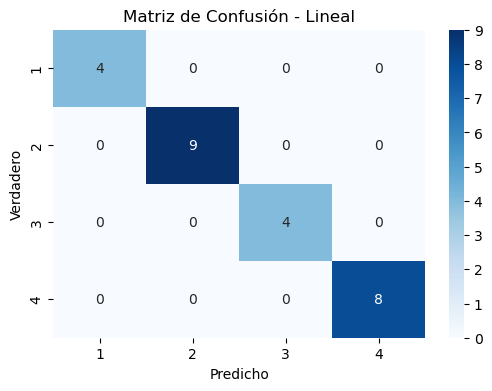


=== Evaluación modelo Polinomial (grado 3) ===
Exactitud: 0.9200

Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       0.82      1.00      0.90         9
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         8

    accuracy                           0.92        25
   macro avg       0.95      0.88      0.89        25
weighted avg       0.93      0.92      0.91        25



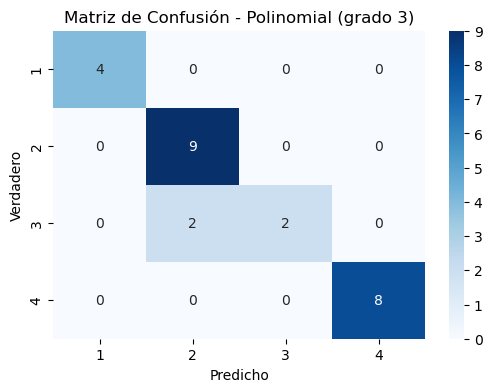


=== Evaluación modelo RBF ===
Exactitud: 1.0000

Reporte de clasificación:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         8

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



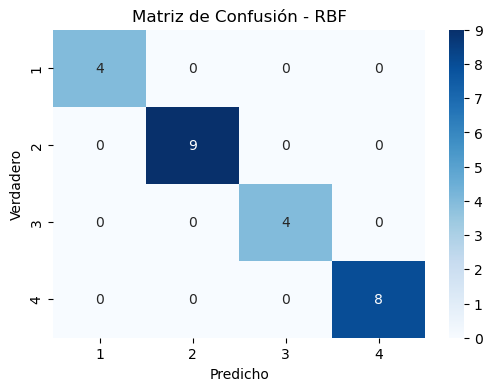

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in models.items():
    print(f"\n=== Evaluación modelo {name} ===")
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Métricas
    print(f"Exactitud: {accuracy_score(y_test, y_pred):.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.title(f'Matriz de Confusión - {name}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()

# Análisis:
Tanto el modelo lineal como el RBF alcanzaron una exactitud perfecta (100%), clasificando correctamente todos los casos (F1-score=1.00 en todas las clases), lo que sugiere una separabilidad óptima de los datos con estos kernels. El modelo polinomial (grado 3) mostró un rendimiento ligeramente inferior (92% exactitud), con dificultades específicas en la clase 3 (recall=0.50, F1=0.67), indicando posibles limitaciones para capturar patrones complejos en esta categoría. La consistencia del RBF y el lineal en todas las métricas (precisión, recall y F1) los posiciona como los mejores candidatos, aunque el kernel lineal podría preferirse por su simplicidad computacional al ofrecer el mismo rendimiento perfecto. El polinomial, aunque útil, requeriría ajustes (ej. modificar el grado o parámetros de regularización) para mejorar su capacidad predictiva en la clase 3.

Mientras que los resultados sugieren que el lineal y RBF son óptimos, la perfección es estadísticamente sospechosa. El polinomial (92%) podría ser más realista, y su error en la clase 3 merece investigación. Yo personalemente de debo la exactitud del 100% a la selexxipon d genomas y la fuga de datos que tenemos en el código que permite correr más rápido el sistema.

Referencias: 

OpenAI. (2025). ChatGPT (versión GPT-4) [Modelo de lenguaje grande]. https://chat.openai.com/